In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict


Populating the interactive namespace from numpy and matplotlib


In [2]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [3]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [4]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/afs/inf.ed.ac.uk/user/s17/s1709221/miniconda3/envs/mlp/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [6]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

#opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)

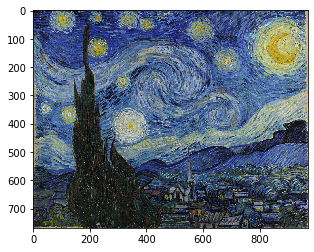

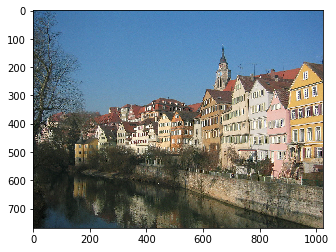

In [7]:
#display images
for img in imgs:
    imshow(img);show()

In [8]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r12']
loss_layers = style_layers + content_layers
style_loss_fns=[GramMSELoss()] * len(style_layers)
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

0 100
Iteration: 10, loss: 19092170.000000
Iteration: 20, loss: 4389389.000000
20 100
Iteration: 30, loss: 2108828.000000
Iteration: 40, loss: 1226618.125000
40 100
Iteration: 50, loss: 813522.937500
Iteration: 60, loss: 590265.187500
60 100
Iteration: 70, loss: 465834.625000
Iteration: 80, loss: 359408.875000
80 100
Iteration: 90, loss: 299397.937500
Iteration: 100, loss: 246258.046875
100 100
Iteration: 110, loss: 202301.578125
Iteration: 120, loss: 170665.796875


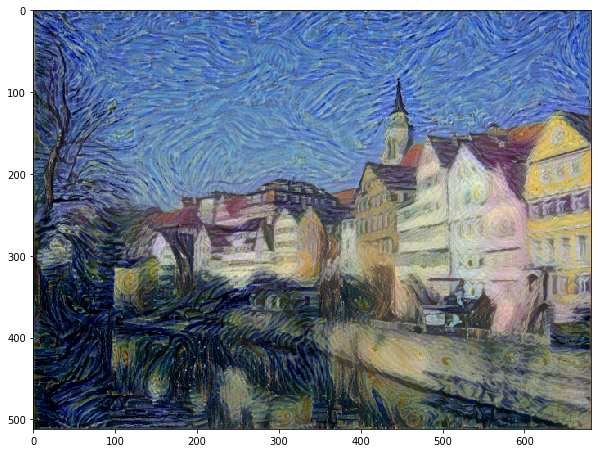

In [9]:
#run style transfer
max_iter = 100
show_iter = 10
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:
    print(n_iter[0],max_iter)
    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data.cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

## Style only

In [12]:
style_layers = ['r12','r22','r34','r44', 'r54'] 
#style_layers = ['r12','r22'] 
style_loss_fns=[GramMSELoss()] * len(style_layers)
if torch.cuda.is_available():
    style_loss_fns = [loss_fn.cuda() for loss_fn in style_loss_fns]
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]


0 500
2 500
Iteration: 10, loss: 2107501568.000000
Iteration: 20, loss: 461458528.000000
22 500
Iteration: 30, loss: 188408480.000000
Iteration: 40, loss: 108654616.000000
42 500
Iteration: 50, loss: 54400380.000000
Iteration: 60, loss: 20597824.000000
62 500
Iteration: 70, loss: 13140852.000000
Iteration: 80, loss: 10707573.000000
82 500
Iteration: 90, loss: 9179746.000000
Iteration: 100, loss: 7972954.000000
102 500
Iteration: 110, loss: 6956430.500000
Iteration: 120, loss: 6040009.000000
122 500
Iteration: 130, loss: 5126448.000000
Iteration: 140, loss: 4277816.500000
142 500
Iteration: 150, loss: 3606363.000000
Iteration: 160, loss: 3156790.000000
162 500
Iteration: 170, loss: 2722286.250000
Iteration: 180, loss: 2417951.000000
182 500
Iteration: 190, loss: 2208856.000000
Iteration: 200, loss: 2053058.375000
202 500
Iteration: 210, loss: 1913905.125000
Iteration: 220, loss: 1769938.500000
222 500
Iteration: 230, loss: 1629099.250000
Iteration: 240, loss: 1491542.125000
242 500
Iter

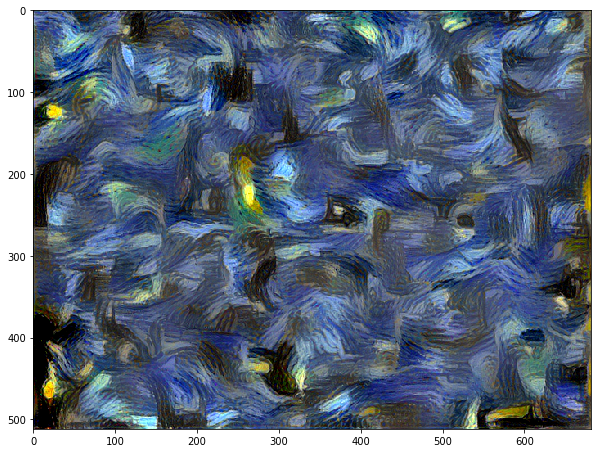

In [14]:
#run style transfer
opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init

max_iter = 500
show_iter = 10
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:
    print(n_iter[0],max_iter)
    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, style_layers)
        layer_losses = [style_weights[a] * style_loss_fns[a](A, style_targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data.cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

## Content Only

In [18]:
#define layers, loss functions, weights and compute optimization targets
content_layers = ['r54']
content_loss_fns=[nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    content_loss_fns = [loss_fn.cuda() for loss_fn in content_loss_fns]
    
#these are good weights settings:
content_weights = [1e0]

#compute optimization targets
content_targets = [A.detach() for A in vgg(content_image, content_layers)]

0 100
Iteration: 10, loss: 7.027974
Iteration: 20, loss: 4.299242
20 100
Iteration: 30, loss: 2.441096
Iteration: 40, loss: 1.658571
40 100
Iteration: 50, loss: 1.290731
Iteration: 60, loss: 1.088145
60 100
Iteration: 70, loss: 0.939282
Iteration: 80, loss: 0.831136
80 100
Iteration: 90, loss: 0.751728
Iteration: 100, loss: 0.687121
100 100
Iteration: 110, loss: 0.634950
Iteration: 120, loss: 0.585243


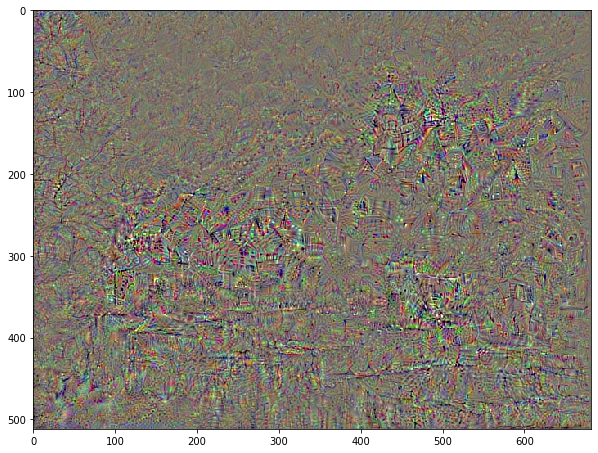

In [19]:
#run style transfer
#opt_img = Variable(content_image.data.clone(), requires_grad=True)
opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
max_iter = 100
show_iter = 10
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:
    print(n_iter[0],max_iter)
    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, content_layers)
        layer_losses = [content_weights[a] * content_loss_fns[a](A, content_targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data.cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)